# Install libs

In [1]:
!pip install vibdata==1.1.1 signalAI==0.0.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.9 MB/s eta 0:00:0000:0100:01


# Import Libs

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Basic imports
import numpy as np
import numpy.typing as npt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# vibdata
import vibdata.raw as raw_datasets
from vibdata.deep.DeepDataset import DeepDataset, convertDataset
from vibdata.deep.signal.transforms import (
    Sequential,
    SplitSampleRate,
    FeatureExtractor,
    FilterByValue,
    Split
)
from vibdata.deep.signal.core import SignalSample

# SignalAI
from signalAI.experiments.features_1d import Features1DExperiment
from signalAI.utils.group_dataset import GroupDataset
from signalAI.utils.fold_idx_generator import (
    FoldIdxGeneratorUnbiased,
    FoldIdxGeneratorBiased,
)

class GroupCWRULoad(GroupDataset):
    @staticmethod
    def _assigne_group(sample: SignalSample) -> int:
        return sample["metainfo"]["load"]

# Deep Learning Experiments

## Import CRWU dataset

In [3]:
raw_root_dir = "../data/raw_data/cwru"
raw_dataset = raw_datasets.CWRU_raw(raw_root_dir, download=True)

Cached downloading...
Hash: md5:d7d3042161080fc82e99d78464fa2914
From (original): https://drive.google.com/uc?id=1G2vfms1QDlkdzqL_LAQdMIQAoludxBNj
From (redirected): https://drive.google.com/uc?id=1G2vfms1QDlkdzqL_LAQdMIQAoludxBNj&confirm=t&uuid=5d1b5f2d-9078-4825-add2-e4eb60a64d6f
To: ../data/raw_data/cwru/CWRU_raw/CWRU.zip
100%|██████████| 245M/245M [00:02<00:00, 106MB/s]  


## Time domain

### Filter by 12k SampleRate

In [4]:
transforms_time = Sequential(
    [
        SplitSampleRate()
    ]
)
print(transforms_time)

Sequential(transforms=[SplitSampleRate()])


In [5]:
deep_root_dir_time = "../data/deep_data/deep_learning"
deep_dataset_time = convertDataset(raw_dataset,filter=FilterByValue(on_field="sample_rate", values=12000),transforms=transforms_time, dir_path=deep_root_dir_time, batch_size=32)

Transformando


Converting CWRU: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


## Generate Unbiased Folds Single Round

In [6]:
folds_singleround_deep = FoldIdxGeneratorUnbiased(deep_dataset_time, GroupCWRULoad , dataset_name="CWRU12k_single").generate_folds()
folds_singleround_deep

Grouping dataset: 100%|██████████| 2520/2520 [00:00<00:00, 5309.26sample/s]


array([0., 0., 0., ..., 3., 3., 3.])

## Generate Unbiased Folds MultiRound

In [ ]:
# class GroupMultiRoundCWRULoad(GroupDataset):
#     @staticmethod
#     def _assigne_group(sample: SignalSample) -> int:
#         sample_metainfo = sample["metainfo"]
#         return sample_metainfo["label"].astype(str) + " " + sample_metainfo["load"].astype(int).astype(str)

# CLASS_DEF = {0: "N", 1: "O", 2: "I", 3: "R"}
# CONDITION_DEF = {"0": "0", "1": "1", "2": "2", "3": "3"}
# folds_multiround_deep = FoldIdxGeneratorUnbiased(deep_dataset_time, GroupMultiRoundCWRULoad, dataset_name="CWRU12k_multi", multiround=True, class_def=CLASS_DEF, condition_def=CONDITION_DEF).generate_folds()
# folds_multiround_deep

## DeepLearning Experiments

### Utils

In [7]:
# vibclassifier/experiments/base.py
from abc import ABC, abstractmethod
import json
from typing import Optional, Dict, Any
from vibdata.raw.base import RawVibrationDataset
from vibdata.deep.signal.transforms import Transform

class Experiment(ABC):
    """Classe base abstrata para todos os experimentos de classificação de vibração."""

    def __init__(
        self,
        name: str,
        description: str,
        dataset: Optional[RawVibrationDataset] = None,
        data_transform: Optional[Transform] = None,
        feature_selector = None,
        model = None
    ):
        """
        Inicializa o experimento.

        Args:
            name: Nome identificador do experimento
            description: Descrição detalhada do experimento
            dataset: Conjunto de dados de vibração
            data_transform: Transformação a ser aplicada nos dados brutos
            data_division_method: Método de divisão dos dados (e.g., 'kfold', 'holdout')
            data_division_params: Parâmetros para o método de divisão
            feature_selector: Seletor de features (para experimentos com extração)
            model: Modelo de machine learning/deep learning
        """
        self.name = name
        self.description = description
        self.dataset = dataset
        self.data_transform = data_transform
        self.feature_selector = feature_selector
        self.model = model

        # Resultados serão armazenados aqui
        self.results = {}

    @abstractmethod
    def prepare_data(self):
        """Prepara os dados para o experimento."""
        pass

    @abstractmethod
    def run(self):
        """Executa o experimento completo."""
        pass

    def save_results(self, filepath: str):
        """Salva os resultados do experimento."""
        # Implementação básica - pode ser extendida
        with open(filepath, 'w') as f:
            json.dump(self.results, f)

    def load_results(self, filepath: str):
        """Carrega resultados de um experimento anterior."""
        with open(filepath, 'r') as f:
            self.results = json.load(f)

    def __str__(self):
        return f"Experiment: {self.name}\nDescription: {self.description}"

In [8]:
# vibclassifier/experiments/deep_torch.py
import os
import time
import json
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import numpy as np
from typing import List, Dict, Optional, Tuple, Union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from signalAI.utils.metrics import calculate_metrics
from signalAI.utils.experiment_result import ExperimentResults, FoldResults
import copy

class TorchVibrationDataset(Dataset):
    """Wrapper to convert dataset samples into Torch tensors."""
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Função auxiliar KL
def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(rho_hat, dim=0)
    rho = torch.tensor([rho] * len(rho_hat), device=rho_hat.device)
    epsilon = 1e-7
    term1 = rho * torch.log((rho + epsilon) / (rho_hat + epsilon))
    term2 = (1 - rho) * torch.log((1 - rho + epsilon) / (1 - rho_hat + epsilon))
    return torch.sum(term1 + term2)

class DeepLearningExperiment(Experiment):
    def __init__(
        self,
        name: str,
        description: str,
        dataset,
        data_fold_idxs: List[int],
        model: nn.Module,
        criterion: Optional[nn.Module] = None,
        # Parâmetros adaptados para o autoencoder
        reconstruction_criterion: Optional[nn.Module] = None,
        recon_loss_weight: float = 1.0,
        sparsity_target: Optional[float] = None,
        sparsity_weight: float = 0.0,
        pretrain_epochs: int = 0, # Épocas de treinamento do autoencoder
        optimizer_class: Optional[torch.optim.Optimizer] = optim.Adam,
        batch_size: int = 32,
        lr: float = 1e-3,
        num_epochs: int = 20, # Épocas de treino do classificador
        val_split: float = 0.2,
        output_dir: str = "results_torch",
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        **kwargs
    ):
        super().__init__(name, description, dataset, model=model, **kwargs)
        self.data_fold_idxs = data_fold_idxs
        self.output_dir = Path(output_dir)
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.pretrain_epochs = pretrain_epochs
        self.val_split = val_split
        self.device = device
        self.optimizer_class = optimizer_class
        self.lr = lr
        self.criterion = criterion if criterion is not None else nn.CrossEntropyLoss()
        
        self.reconstruction_criterion = reconstruction_criterion
        self.recon_loss_weight = recon_loss_weight
        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight
        
        self.is_sae_task = self.sparsity_target is not None and self.sparsity_weight > 0.0
        # Define tipo do AutoEncoder utilizado
        self.is_autoencoder_task = reconstruction_criterion is not None or self.is_sae_task or "AE1D" in model.__class__.__name__

        if self.is_sae_task and self.reconstruction_criterion is None:
             print("Warning: SAE task detected but no reconstruction_criterion. Defaulting to MSELoss.")
             self.reconstruction_criterion = nn.MSELoss()

        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
            model = torch.nn.DataParallel(model) 
        
        # Guarda encoder e decoder
        self.original_model = model.module if isinstance(model, nn.DataParallel) else model

        self.n_outer_folds = len(np.unique(data_fold_idxs))
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.prepare_data()

    def prepare_data(self):
        features, labels = [], []
        for sample in self.dataset:
            features.append(sample['signal'][0]) 
            labels.append(sample['metainfo']['label'])
        self.X = np.array(features)
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(labels)

    def _train_one_fold(
        self, X_train, y_train, X_test, y_test, fold_idx: int
    ) -> FoldResults:
        
        train_dataset = TorchVibrationDataset(X_train, y_train)
        test_dataset = TorchVibrationDataset(X_test, y_test)
        val_size = int(self.val_split * len(train_dataset))
        train_size = len(train_dataset) - val_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        model = copy.deepcopy(self.model.to(self.device))
        model_core = model.module if isinstance(model, nn.DataParallel) else model

        # Verificação da estrutura de AE (encoder, decoder, classifier)
        has_ae_structure = hasattr(model_core, 'encoder') and hasattr(model_core, 'decoder') and hasattr(model_core, 'classifier')

        # Treinamento do AutoEncoder
        if self.is_autoencoder_task and self.pretrain_epochs > 0 and has_ae_structure:
            print(f"[Fold {fold_idx}] AutoEncoder training ({self.pretrain_epochs} epochs)...")
            
            # Otimizador Encoder + Decoder
            optimizer_ae = self.optimizer_class([
                {'params': model_core.encoder.parameters()},
                {'params': model_core.decoder.parameters()}
            ], lr=self.lr)

            for epoch in range(self.pretrain_epochs):
                model.train()
                running_recon_loss = 0.0
                
                for xb, _ in train_loader:
                    xb = xb.to(self.device)
                    input_data = xb

                    if any(isinstance(m, nn.Conv1d) for m in model.modules()) and xb.ndim == 2:
                        xb = xb.unsqueeze(1)
                    elif any(isinstance(m, nn.Conv2d) for m in model.modules()) and xb.ndim == 2:
                         side = int(np.sqrt(xb.shape[1])); xb = xb.view(xb.size(0), 1, side, side)

                    optimizer_ae.zero_grad()
                    outputs = model(xb) # (class, recon, [sparsity])

                    if isinstance(outputs, tuple):
                        # Foco na reconstrução
                        reconstruction = outputs[1] 
                        
                        loss = self.reconstruction_criterion(reconstruction, input_data)
                        
                        # Adiciona esparsidade se for SAE
                        if self.is_sae_task and len(outputs) > 2:
                            latent_features = outputs[2]
                            loss += self.sparsity_weight * kl_divergence(self.sparsity_target, latent_features)
                        
                        loss.backward()
                        optimizer_ae.step()
                        running_recon_loss += loss.item() * input_data.size(0)
                
                avg_recon_loss = running_recon_loss / len(train_loader.dataset)
                if (epoch + 1) % 5 == 0 or epoch == 0:
                    print(f"  [Pre-train] Epoch {epoch+1}/{self.pretrain_epochs} Recon Loss: {avg_recon_loss:.4f}")

        # Treino do classificador
        print(f"[Fold {fold_idx}] Classifier training ({self.num_epochs} epochs)...")

        # Define otimizador para a fase supervisionada
        if has_ae_structure and self.is_autoencoder_task:
            # Se for AE: Treina Encoder + Classifier (Decoder congelado ou ignorado pelo otimizador)
            optimizer_clf = self.optimizer_class([
                {'params': model_core.encoder.parameters()},
                {'params': model_core.classifier.parameters()}
            ], lr=self.lr)
        else:
            # Se for MLP/CNN padrão: Treina todos os parâmetros
            optimizer_clf = self.optimizer_class(model.parameters(), lr=self.lr)

        train_losses, val_losses = [], []
        
        for epoch in range(self.num_epochs):
            epoch_start = time.time()
            model.train()
            running_loss = 0.0
            
            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                
                # Ajuste de shape
                if any(isinstance(m, nn.Conv1d) for m in model.modules()) and xb.ndim == 2:
                     xb = xb.unsqueeze(1)
                elif any(isinstance(m, nn.Conv2d) for m in model.modules()) and xb.ndim == 2:
                     side = int(np.sqrt(xb.shape[1])); xb = xb.view(xb.size(0), 1, side, side)

                optimizer_clf.zero_grad()
                outputs = model(xb)

                # Cálculo da perda apenas de CLASSIFICAÇÃO
                if isinstance(outputs, tuple):
                    classification_output = outputs[0] # Pega apenas a classificação
                else:
                    classification_output = outputs # Modelo padrão

                loss = self.criterion(classification_output, yb)
                
                loss.backward()
                optimizer_clf.step()
                running_loss += loss.item() * xb.size(0)

            avg_train_loss = running_loss / len(train_loader.dataset)

            # Validação
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(self.device), yb.to(self.device)
                    # Ajuste de shape
                    if any(isinstance(m, nn.Conv1d) for m in model.modules()) and xb.ndim == 2:
                         xb = xb.unsqueeze(1)
                    elif any(isinstance(m, nn.Conv2d) for m in model.modules()) and xb.ndim == 2:
                         side = int(np.sqrt(xb.shape[1])); xb = xb.view(xb.size(0), 1, side, side)

                    outputs = model(xb)
                    
                    if isinstance(outputs, tuple):
                        classification_output = outputs[0]
                    else:
                        classification_output = outputs

                    loss = self.criterion(classification_output, yb)
                    val_loss += loss.item() * xb.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            
            epoch_time = time.time() - epoch_start
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"  [Supervised] Epoch {epoch+1}/{self.num_epochs} Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.2f}s")

        plt.figure()
        plt.plot(train_losses, label="Train Loss (Clf)")
        plt.plot(val_losses, label="Val Loss (Clf)")
        plt.legend(); plt.title(f"Loss Curve - Fold {fold_idx}")
        plt.savefig(os.path.join(self.dir_path, f"loss_curve_fold{fold_idx}_{self.start_time}.png")); plt.close()
        
        torch.save(model_core.state_dict(), os.path.join(self.dir_path, f"model_fold{fold_idx}.pt"))

        # Teste
        y_true, y_pred, y_proba = [], [], []
        model.eval()
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                if any(isinstance(m, nn.Conv1d) for m in model.modules()) and xb.ndim == 2:
                     xb = xb.unsqueeze(1)
                elif any(isinstance(m, nn.Conv2d) for m in model.modules()) and xb.ndim == 2:
                     side = int(np.sqrt(xb.shape[1])); xb = xb.view(xb.size(0), 1, side, side)

                outputs = model(xb)
                if isinstance(outputs, tuple):
                    classification_output = outputs[0]
                else:
                    classification_output = outputs

                probs = torch.softmax(classification_output, dim=1)
                preds = torch.argmax(probs, dim=1)
                y_true.extend(yb.cpu().numpy()); y_pred.extend(preds.cpu().numpy()); y_proba.extend(probs.cpu().numpy())

        metrics = calculate_metrics(np.array(y_true), np.array(y_pred), np.array(y_proba))
        return FoldResults(fold_idx, np.array(y_true), np.array(y_pred), np.array(y_proba), metrics)

    def run(self) -> ExperimentResults:
        self.start_time = time.strftime("%Y%m%d_%H%M%S")
        self.dir_path = os.path.join(self.output_dir, f"results_{self.name}_{self.start_time}")
        os.makedirs(self.dir_path, exist_ok=True)

        results = ExperimentResults(
            experiment_name=self.name, description=self.description,
            model_name=self.original_model.__class__.__name__, feature_names=None,
            config={'n_outer_folds': self.n_outer_folds, 'pretrain_epochs': self.pretrain_epochs, 
                    'finetune_epochs': self.num_epochs, 'batch_size': self.batch_size, 'lr': self.lr}
        )

        for outer_fold in range(self.n_outer_folds):
            print(f"\n=== Outer Fold {outer_fold+1}/{self.n_outer_folds} ===")
            train_mask = self.data_fold_idxs != outer_fold
            test_mask = self.data_fold_idxs == outer_fold
            
            try:
                fold_result = self._train_one_fold(self.X[train_mask], self.y[train_mask], self.X[test_mask], self.y[test_mask], outer_fold)
                results.add_fold_result(fold_result)
                print(f"  Result: Acc={fold_result.metrics['accuracy']:.4f}, F1={fold_result.metrics['f1']:.4f}")
            except Exception as e:
                print(f"Error in fold {outer_fold}: {e}")
                import traceback; traceback.print_exc()

        results.calculate_overall_metrics()
        results.save_json(os.path.join(self.dir_path, f"results.json"))
        print("\n=== Final Results ===")
        print(f"Mean Accuracy: {results.overall_metrics['accuracy']:.4f}")
        return results

### 1D MLP adaptado para 12k

In [9]:
class MLP1D_12k(nn.Module):
    def __init__(self, input_length: int = 12000, num_classes: int = 4):
        super().__init__()
        
        # Camada adicional para adaptar a entrada de 12000 para 1024 progressivamente
        self.adaptation_layers = nn.Sequential(
            # 12000 -> 4096
            nn.Linear(input_length, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7), # Dropout alto para evitar overfitting na entrada

            # 4096 -> 2048
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            # 2048 -> 1024 (Conecta com a arquitetura original)
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )

        # Arquitetura original:        
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )

        self.fc4 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )

        self.fc5 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )

        self.fc6 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )

        self.fc7 = nn.Sequential(
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out = torch.flatten(x, 1)
        
        # Passa pela adaptação primeiro
        out = self.adaptation_layers(out)
        
        # Segue o fluxo normal
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = self.fc7(out)
        
        return out

In [10]:
# suppose dataset is already a DeepDataset like before
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")
model = MLP1D_12k(input_length=input_length, num_classes=num_classes)

exp = DeepLearningExperiment(
    name="mlp1d_vibration_12k_optimized",
    description="1D MLP for vibration signals",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,  # numpy array of fold indexes
    model=model,
    batch_size=64,
    lr=3e-4,
    pretrain_epochs=0,
    num_epochs=100
)

results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] Classifier training (100 epochs)...
  [Supervised] Epoch 1/100 Train Loss: 1.3473, Val Loss: 1.4525, Time: 1.29s
  [Supervised] Epoch 5/100 Train Loss: 0.9189, Val Loss: 1.6659, Time: 0.65s
  [Supervised] Epoch 10/100 Train Loss: 0.3335, Val Loss: 1.3209, Time: 0.63s
  [Supervised] Epoch 15/100 Train Loss: 0.1967, Val Loss: 1.5133, Time: 0.63s
  [Supervised] Epoch 20/100 Train Loss: 0.1541, Val Loss: 1.4366, Time: 0.63s
  [Supervised] Epoch 25/100 Train Loss: 0.1179, Val Loss: 1.4842, Time: 0.67s
  [Supervised] Epoch 30/100 Train Loss: 0.1137, Val Loss: 1.3998, Time: 0.62s
  [Supervised] Epoch 35/100 Train Loss: 0.0897, Val Loss: 1.4969, Time: 0.63s
  [Supervised] Epoch 40/100 Train Loss: 0.0964, Val Loss: 1.4648, Time: 0.63s
  [Supervised] Epoch 45/100 Train Loss: 0.0948, Val Loss: 1.6250, Time: 0.63s
  [Supervised] Epoch 50/100 Train Loss: 0.0847, Val Loss: 1.5170, Time: 0.63s
  [Supervised] Epoch 55/100 Train Loss:

EXPERIMENTO: mlp1d_vibration_12k_optimized
DESCRIÇÃO: 1D MLP for vibration signals
MODELO: MLP1D_12k
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.4377
Desvio Padrão Acurácia ±0.0492
        F1-Score Médio  0.4147
Desvio Padrão F1-Score ±0.0479

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.3617   0.3389    0.3826 0.3617
    2   0.4578   0.4363    0.5140 0.4578
    3   0.4969   0.4694    0.5010 0.4969
    4   0.4344   0.4141    0.4878 0.4344


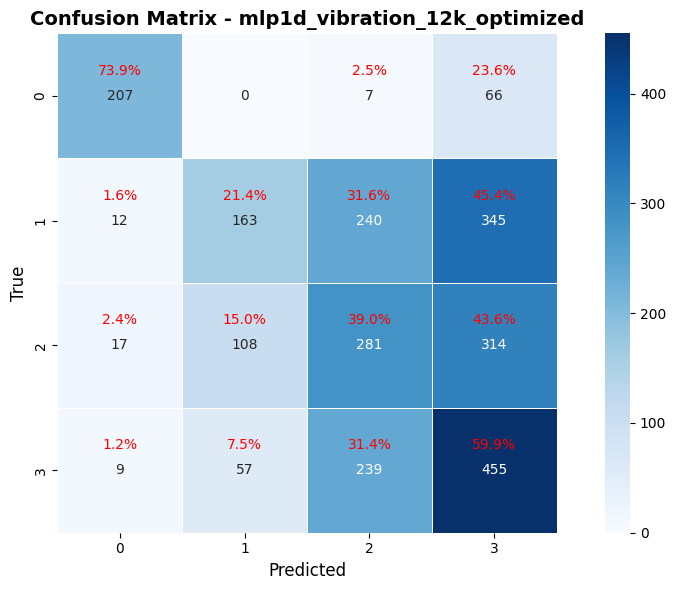


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.4389
Total de Amostras: 2520


In [11]:
results.show_results()

### 1D AutoEncoder

In [12]:
import torch
import torch.nn as nn

class AE1D_12k(nn.Module):
    """
    Implementação do Autoencoder 1D Adaptado para 12k pontos.
    Arquitetura: 12000 -> 512 -> 256 -> 128 -> 64 (Latent) -> 128 -> 256 -> 512 -> 12000.
    """
    def __init__(self, input_length: int = 12000, latent_dim: int = 64, num_classes: int = 4, dropout_rate: float = 0.4):
        super(AE1D_12k, self).__init__()
        
        # --- Encoder ---
        self.encoder = nn.Sequential(
            # Camada 1: Compressão Direta (12000 -> 512)
            nn.Linear(input_length, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            # Camada 2: 512 -> 256
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            # Camada 3: 256 -> 128
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            # Camada Latente: 128 -> 64
            nn.Linear(128, latent_dim)
        )

        # --- Decoder ---
        # Simétrico ao encoder
        self.decoder = nn.Sequential(
            # Latente -> 128
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            # 128 -> 256
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            # 256 -> 512
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            # Reconstrução Final: 512 -> 12000
            nn.Linear(512, input_length)
        )

        # Classificador (Fine-tuning)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        # Flatten para garantir (Batch, 12000)
        x = torch.flatten(x, 1)
        
        # Encoder
        latent_features = self.encoder(x)
        
        # Decoder (Reconstrução do sinal de 12k)
        reconstruction = self.decoder(latent_features)
        
        # Classifier
        classification_output = self.classifier(latent_features)
        
        return classification_output, reconstruction, latent_features

In [13]:
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")
model = AE1D_12k(input_length=input_length, latent_dim=64, num_classes=num_classes)

# Defina os critérios
classification_criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()

exp = DeepLearningExperiment(
    name="ae1d_vibration_combined_loss",
    description="1D AE for vibration signals (Combined Loss)",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,
    model=model,
    reconstruction_criterion=reconstruction_criterion, # critério para treinamento do autoencoder
    criterion=classification_criterion,                # critério para treinamento do classificador
    pretrain_epochs=50,  # Treina Encoder+Decoder apenas com MSELoss
    num_epochs=50,       # Treina Encoder+Classifier apenas com CrossEntropy
    recon_loss_weight=1.0, # recon_loss_weight pode ser 1.0 (pois é a única loss na fase 1)
    batch_size=64,
    lr=3e-4
)

results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] AutoEncoder training (50 epochs)...
  [Pre-train] Epoch 1/50 Recon Loss: 0.1955
  [Pre-train] Epoch 5/50 Recon Loss: 0.1303
  [Pre-train] Epoch 10/50 Recon Loss: 0.1301
  [Pre-train] Epoch 15/50 Recon Loss: 0.1299
  [Pre-train] Epoch 20/50 Recon Loss: 0.1294
  [Pre-train] Epoch 25/50 Recon Loss: 0.1295
  [Pre-train] Epoch 30/50 Recon Loss: 0.1293
  [Pre-train] Epoch 35/50 Recon Loss: 0.1294
  [Pre-train] Epoch 40/50 Recon Loss: 0.1291
  [Pre-train] Epoch 45/50 Recon Loss: 0.1291
  [Pre-train] Epoch 50/50 Recon Loss: 0.1288
[Fold 0] Classifier training (50 epochs)...
  [Supervised] Epoch 1/50 Train Loss: 1.4074, Val Loss: 1.3711, Time: 0.17s
  [Supervised] Epoch 5/50 Train Loss: 1.1244, Val Loss: 1.2758, Time: 0.17s
  [Supervised] Epoch 10/50 Train Loss: 0.4499, Val Loss: 1.1540, Time: 0.17s
  [Supervised] Epoch 15/50 Train Loss: 0.1703, Val Loss: 1.1877, Time: 0.17s
  [Supervised] Epoch 20/50 Train Loss: 0.1081, Val L

EXPERIMENTO: ae1d_vibration_combined_loss
DESCRIÇÃO: 1D AE for vibration signals (Combined Loss)
MODELO: AE1D_12k
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.4378
Desvio Padrão Acurácia ±0.0581
        F1-Score Médio  0.4207
Desvio Padrão F1-Score ±0.0516

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.3450   0.3348    0.3442 0.3450
    2   0.4406   0.4287    0.4420 0.4406
    3   0.5031   0.4698    0.5104 0.5031
    4   0.4625   0.4493    0.4783 0.4625


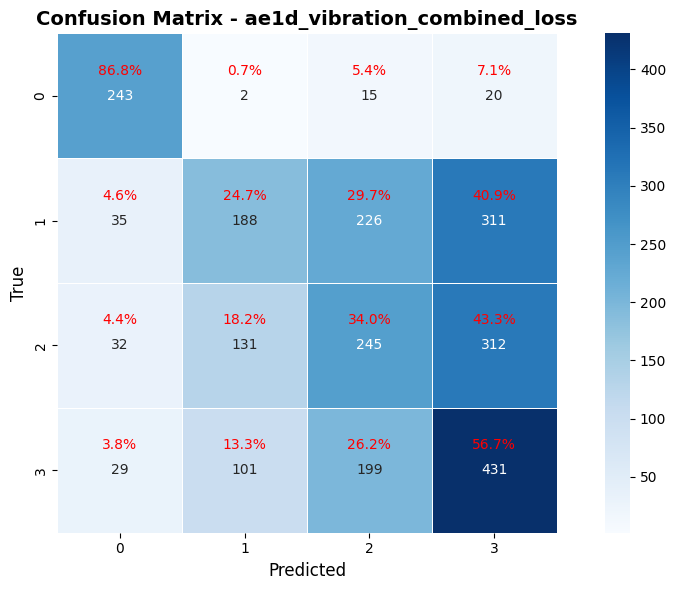


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.4393
Total de Amostras: 2520


In [14]:
results.show_results()

### 1D Sparse AutoEncoder

In [15]:
class SAE1D_12k(nn.Module):
    """
    Implementação do Sparse Autoencoder 1D adaptado para 12k pontos.
    Arquitetura: 12000 -> 512 -> 256 -> 128 -> 64 (Latent).
    """
    def __init__(self, input_length: int = 12000, latent_dim: int = 64, num_classes: int = 4):
        super(SAE1D_12k, self).__init__()
        
        # --- Encoder ---
        self.encoder = nn.Sequential(
            # Camada 1: Compressão Direta (12000 -> 512)
            # Redução drástica necessária para viabilidade
            nn.Linear(input_length, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2), # Adicionado Dropout leve

            # Camada 2: 512 -> 256
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            # Camada 3: 256 -> 128
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            # Camada Latente: 128 -> Latent Dim
            nn.Linear(128, latent_dim)
        )

        # A Sigmoid é OBRIGATÓRIA para SAE se você usar KL Divergence Loss
        # Ela força os neurônios latentes a ficarem entre [0, 1] (probabilidade de ativação)
        self.sparsity_activation = nn.Sigmoid()

        # --- Decoder ---
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            # Reconstrução: 512 -> 12000
            nn.Linear(512, input_length)
        )

        # Classificador (Fine-tuning)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        # Garante (Batch, 12000)
        x = torch.flatten(x, 1)

        # 1. Codificação Linear
        features = self.encoder(x)
        
        # 2. Ativação Esparsa (Latent Space)
        # Importante: A saída aqui estará entre 0 e 1
        latent_features = self.sparsity_activation(features)

        # 3. Reconstrução
        reconstruction = self.decoder(latent_features)

        # 4. Classificação
        classification_output = self.classifier(latent_features)

        return classification_output, reconstruction, latent_features

In [16]:
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")

model = SAE1D_12k(input_length=input_length, latent_dim=64, num_classes=num_classes)

# loss criterions
classification_criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()

exp = DeepLearningExperiment(
    name="sae1d_vibration_sequential",
    description="1D Sparse AE for vibration signals (Sequential Training)",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,
    model=model,
    reconstruction_criterion=reconstruction_criterion, # ae train
    criterion=classification_criterion,                # classifier train
    pretrain_epochs=50,  # Treina Encoder+Decoder com MSE + Esparsidade KL
    num_epochs=50,       # Treina Encoder+Classifier com CrossEntropy
    sparsity_target=0.05,  # (Rho) Nível de esparsidade desejado (ex: 5% dos neurônios ativos) 
    sparsity_weight=1.0,   # (Beta) Peso da penalidade KL na perda total
    recon_loss_weight=1.0, # Peso da reconstrução (geralmente 1.0 na fase de pré-treino puro)
    batch_size=64,
    lr=3e-4
)

results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] AutoEncoder training (50 epochs)...
  [Pre-train] Epoch 1/50 Recon Loss: 28.2598
  [Pre-train] Epoch 5/50 Recon Loss: 5.7388
  [Pre-train] Epoch 10/50 Recon Loss: 0.5001
  [Pre-train] Epoch 15/50 Recon Loss: 0.1556
  [Pre-train] Epoch 20/50 Recon Loss: 0.1315
  [Pre-train] Epoch 25/50 Recon Loss: 0.1314
  [Pre-train] Epoch 30/50 Recon Loss: 0.1338
  [Pre-train] Epoch 35/50 Recon Loss: 0.1328
  [Pre-train] Epoch 40/50 Recon Loss: 0.1340
  [Pre-train] Epoch 45/50 Recon Loss: 0.1344
  [Pre-train] Epoch 50/50 Recon Loss: 0.1278
[Fold 0] Classifier training (50 epochs)...
  [Supervised] Epoch 1/50 Train Loss: 1.3838, Val Loss: 1.3730, Time: 0.17s
  [Supervised] Epoch 5/50 Train Loss: 1.0202, Val Loss: 1.2216, Time: 0.17s
  [Supervised] Epoch 10/50 Train Loss: 0.5187, Val Loss: 1.0856, Time: 0.17s
  [Supervised] Epoch 15/50 Train Loss: 0.2824, Val Loss: 1.1248, Time: 0.17s
  [Supervised] Epoch 20/50 Train Loss: 0.1889, Val 

EXPERIMENTO: sae1d_vibration_sequential
DESCRIÇÃO: 1D Sparse AE for vibration signals (Sequential Training)
MODELO: SAE1D_12k
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.4574
Desvio Padrão Acurácia ±0.0424
        F1-Score Médio  0.4417
Desvio Padrão F1-Score ±0.0376

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.3983   0.3913    0.3953 0.3983
    2   0.4453   0.4256    0.4686 0.4453
    3   0.5156   0.4928    0.5219 0.5156
    4   0.4703   0.4570    0.4944 0.4703


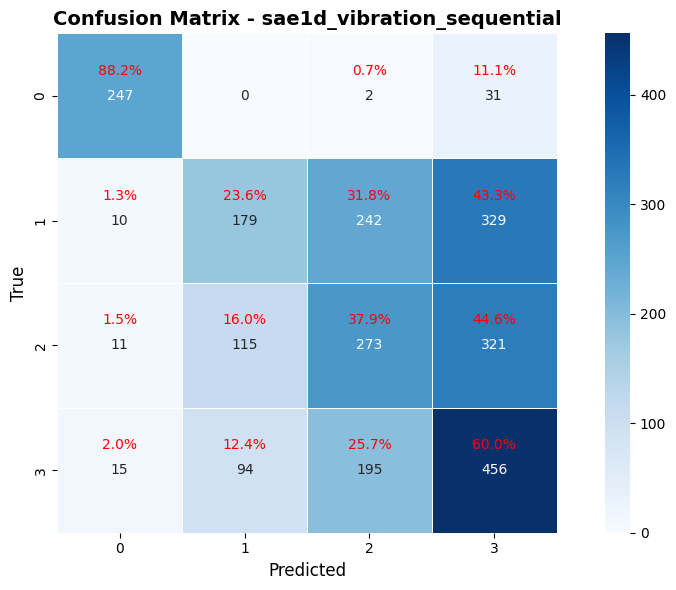


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.4583
Total de Amostras: 2520


In [17]:
results.show_results()

### 1D Denoising AutoEncoder

In [18]:
class DAE1D_12k(nn.Module):
    """
    Implementação do Denoising Autoencoder (DAE) adaptado para 12k pontos.
    Arquitetura: 12000 -> 512 -> 256 -> 128 -> 64 (Latent).
    """
    def __init__(self, input_length: int = 12000, latent_dim: int = 64, num_classes: int = 4, noise_factor: float = 0.5):
        super(DAE1D_12k, self).__init__()
        self.noise_factor = noise_factor
        
        # Encoder
        self.encoder = nn.Sequential(
            # Camada 1: Compressão Direta (12000 -> 512)
            nn.Linear(input_length, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            # Camada 2: 512 -> 256
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            # Camada 3: 256 -> 128
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            # Latent
            nn.Linear(128, latent_dim)
        )

        # Decoder
        # Simétrico
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            # Reconstrução: 512 -> 12000
            nn.Linear(512, input_length)
        )

        # --- Classificador ---
        self.classifier = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        # (Batch, 12000)
        x = torch.flatten(x, 1)

        # Denoising Injection
        if self.training:
            # Adiciona ruído apenas durante o treino
            noise = torch.randn_like(x) * self.noise_factor
            x_noisy = x + noise
        else:
            x_noisy = x
        
        # Encoder
        latent_features = self.encoder(x_noisy)
        
        # Decoder
        reconstruction = self.decoder(latent_features)
        
        # Classifier
        classification_output = self.classifier(latent_features)

        # (Classification, Reconstruction, Latent[Opcional])
        return classification_output, reconstruction, latent_features

In [19]:
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")

# noise_factor controla o ruído
model = DAE1D_12k(input_length=input_length, latent_dim=64, num_classes=num_classes, noise_factor=0.5)

classification_criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()

# 4. Configuração do Experimento
exp = DeepLearningExperiment(
    name="dae1d_vibration_sequential",
    description="1D Denoising AE for vibration signals (Sequential Training)",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,
    model=model,
    reconstruction_criterion=reconstruction_criterion, # ae train
    criterion=classification_criterion,                # classifier train
    pretrain_epochs=100,  # Treina Encoder+Decoder com MSELoss (DAE)
    num_epochs=100,       # Treina Encoder+Classifier com CrossEntropy
    recon_loss_weight=1.0,
    batch_size=64, # Batch grande ajuda na estabilidade do AE
    lr=3e-4
)

# 5. Execução
results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] AutoEncoder training (100 epochs)...
  [Pre-train] Epoch 1/100 Recon Loss: 0.2151
  [Pre-train] Epoch 5/100 Recon Loss: 0.1248
  [Pre-train] Epoch 10/100 Recon Loss: 0.1243
  [Pre-train] Epoch 15/100 Recon Loss: 0.1236
  [Pre-train] Epoch 20/100 Recon Loss: 0.1233
  [Pre-train] Epoch 25/100 Recon Loss: 0.1228
  [Pre-train] Epoch 30/100 Recon Loss: 0.1223
  [Pre-train] Epoch 35/100 Recon Loss: 0.1216
  [Pre-train] Epoch 40/100 Recon Loss: 0.1201
  [Pre-train] Epoch 45/100 Recon Loss: 0.1192
  [Pre-train] Epoch 50/100 Recon Loss: 0.1168
  [Pre-train] Epoch 55/100 Recon Loss: 0.1156
  [Pre-train] Epoch 60/100 Recon Loss: 0.1125
  [Pre-train] Epoch 65/100 Recon Loss: 0.1119
  [Pre-train] Epoch 70/100 Recon Loss: 0.1087
  [Pre-train] Epoch 75/100 Recon Loss: 0.1060
  [Pre-train] Epoch 80/100 Recon Loss: 0.1038
  [Pre-train] Epoch 85/100 Recon Loss: 0.1003
  [Pre-train] Epoch 90/100 Recon Loss: 0.0966
  [Pre-train] Epoch 95

EXPERIMENTO: dae1d_vibration_sequential
DESCRIÇÃO: 1D Denoising AE for vibration signals (Sequential Training)
MODELO: DAE1D_12k
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.4443
Desvio Padrão Acurácia ±0.0282
        F1-Score Médio  0.3886
Desvio Padrão F1-Score ±0.0328

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.4100   0.3490    0.4243 0.4100
    2   0.4234   0.3634    0.4638 0.4234
    3   0.4766   0.4221    0.4978 0.4766
    4   0.4672   0.4199    0.4986 0.4672


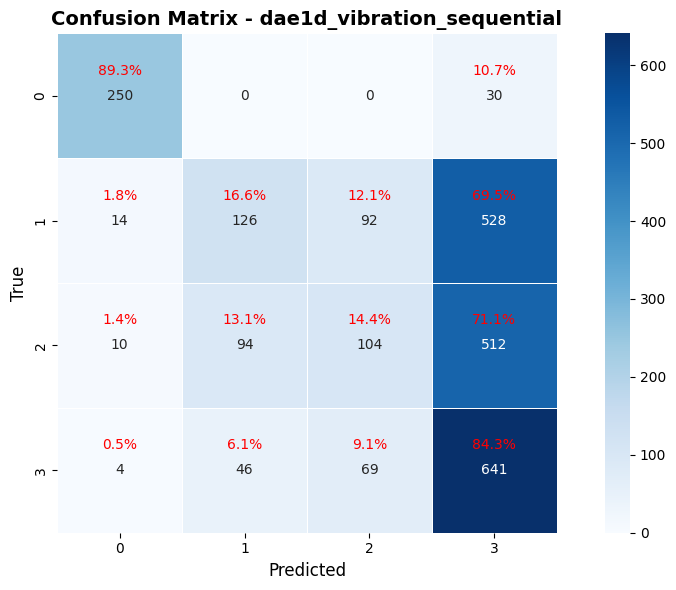


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.4448
Total de Amostras: 2520


In [20]:
results.show_results()

### 1D CNN

In [21]:
class CNN1D(nn.Module):
    def __init__(self, input_length: int, num_classes: int):
        """
        1D CNN for vibration signal classification.
        Args:
            input_length: length of the input signal
            num_classes: number of output classes
        """
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.AdaptiveMaxPool1d(16)  # reduce dynamically to fixed size

        # compute flattened size
        example_input = torch.zeros(1, 1, input_length)  # [B, C, L]
        with torch.no_grad():
            x = self.pool1(F.relu(self.bn1(self.conv1(example_input))))
            x = self.pool2(F.relu(self.bn2(self.conv2(x))))
            x = self.pool3(F.relu(self.bn3(self.conv3(x))))
            flattened_size = x.shape[1] * x.shape[2]

        self.fc1 = nn.Linear(flattened_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: [B, L] or [B, 1, L]
        if x.ndim == 2:
            x = x.unsqueeze(1)  # add channel dim

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
# suppose dataset is already a DeepDataset like before
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")
model = CNN1D(input_length=input_length, num_classes=num_classes)

exp = DeepLearningExperiment(
    name="cnn1d_vibration",
    description="1D CNN for vibration signals",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,  # numpy array of fold indexes
    model=model,
    batch_size=64,
    lr=3e-4,
    num_epochs=100
)

results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] Classifier training (100 epochs)...
  [Supervised] Epoch 1/100 Train Loss: 1.3781, Val Loss: 1.2973, Time: 1.36s
  [Supervised] Epoch 5/100 Train Loss: 0.8975, Val Loss: 0.8201, Time: 0.68s
  [Supervised] Epoch 10/100 Train Loss: 0.5982, Val Loss: 0.5583, Time: 0.68s
  [Supervised] Epoch 15/100 Train Loss: 0.4209, Val Loss: 0.3732, Time: 0.68s
  [Supervised] Epoch 20/100 Train Loss: 0.3153, Val Loss: 0.3434, Time: 0.68s
  [Supervised] Epoch 25/100 Train Loss: 0.2147, Val Loss: 0.1802, Time: 0.68s
  [Supervised] Epoch 30/100 Train Loss: 0.1912, Val Loss: 0.1299, Time: 0.69s
  [Supervised] Epoch 35/100 Train Loss: 0.1532, Val Loss: 0.1047, Time: 0.68s
  [Supervised] Epoch 40/100 Train Loss: 0.1051, Val Loss: 0.0819, Time: 0.68s
  [Supervised] Epoch 45/100 Train Loss: 0.1308, Val Loss: 0.1188, Time: 0.69s
  [Supervised] Epoch 50/100 Train Loss: 0.0799, Val Loss: 0.0864, Time: 0.68s
  [Supervised] Epoch 55/100 Train Loss:

EXPERIMENTO: cnn1d_vibration
DESCRIÇÃO: 1D CNN for vibration signals
MODELO: CNN1D
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.8771
Desvio Padrão Acurácia ±0.0724
        F1-Score Médio  0.8771
Desvio Padrão F1-Score ±0.0722

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.7617   0.7628    0.7964 0.7617
    2   0.9109   0.9129    0.9324 0.9109
    3   0.9578   0.9577    0.9626 0.9578
    4   0.8781   0.8751    0.8831 0.8781


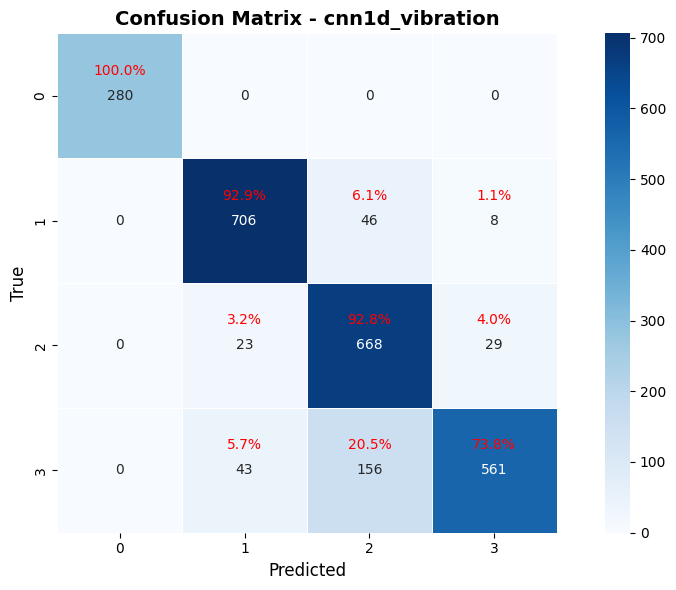


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.8790
Total de Amostras: 2520


In [23]:
results.show_results()

### 1D LeNet

In [24]:
class LeNet1D_12k(nn.Module):
    def __init__(self, in_channel=1, out_channel=4):
        super(LeNet1D_12k, self).__init__()
        
        # --- Bloco Convolucional 1 ---
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channel, 6, kernel_size=64, stride=4, padding=30),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # 3000 -> 1500
        )
        
        # --- Bloco Convolucional 2 ---
        self.conv2 = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(12) 
        )
        
        # --- Classificador (Fully Connected) ---
        # Input achatado: 16 canais * 12 pontos = 192 features
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 12, 120), # Tamanho clássico da LeNet-5
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84), # Tamanho clássico da LeNet-5
            nn.ReLU()
        )
        
        self.fc3 = nn.Linear(84, out_channel)

    def forward(self, x):
        # Garante dimensão de canal (Batch, 1, 12000)
        if x.ndim == 2:
            x = x.unsqueeze(1)
            
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [25]:
# suppose dataset is already a DeepDataset like before
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")
model = LeNet1D_12k(in_channel=1, out_channel=num_classes)

exp = DeepLearningExperiment(
    name="1d_lenet vibration",
    description="1D LeNet for vibration signals",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,  # numpy array of fold indexes
    model=model,
    batch_size=64,
    lr=3e-4,
    num_epochs=100
)

results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] Classifier training (100 epochs)...
  [Supervised] Epoch 1/100 Train Loss: 1.3615, Val Loss: 1.3358, Time: 0.14s
  [Supervised] Epoch 5/100 Train Loss: 1.1832, Val Loss: 1.1661, Time: 0.10s
  [Supervised] Epoch 10/100 Train Loss: 0.9357, Val Loss: 0.9143, Time: 0.10s
  [Supervised] Epoch 15/100 Train Loss: 0.8072, Val Loss: 0.8485, Time: 0.10s
  [Supervised] Epoch 20/100 Train Loss: 0.7359, Val Loss: 0.7412, Time: 0.10s
  [Supervised] Epoch 25/100 Train Loss: 0.6707, Val Loss: 0.6788, Time: 0.10s
  [Supervised] Epoch 30/100 Train Loss: 0.6128, Val Loss: 0.6146, Time: 0.10s
  [Supervised] Epoch 35/100 Train Loss: 0.5714, Val Loss: 0.5545, Time: 0.10s
  [Supervised] Epoch 40/100 Train Loss: 0.5173, Val Loss: 0.5094, Time: 0.10s
  [Supervised] Epoch 45/100 Train Loss: 0.4746, Val Loss: 0.4752, Time: 0.10s
  [Supervised] Epoch 50/100 Train Loss: 0.4250, Val Loss: 0.4226, Time: 0.10s
  [Supervised] Epoch 55/100 Train Loss:

EXPERIMENTO: 1d_lenet vibration
DESCRIÇÃO: 1D LeNet for vibration signals
MODELO: LeNet1D_12k
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.8056
Desvio Padrão Acurácia ±0.0845
        F1-Score Médio  0.8031
Desvio Padrão F1-Score ±0.0860

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.6600   0.6549    0.7104 0.6600
    2   0.8516   0.8476    0.8514 0.8516
    3   0.8672   0.8655    0.8655 0.8672
    4   0.8438   0.8445    0.8475 0.8438


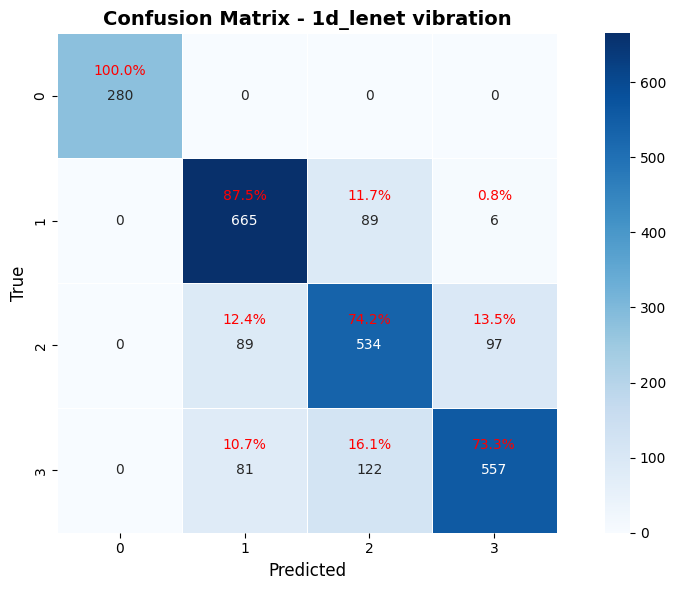


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.8079
Total de Amostras: 2520


In [26]:
results.show_results()

### 1D ResNet18

In [27]:
def conv3x1(in_planes, out_planes, stride=1):
    """3x1 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x1(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet18_12k(nn.Module):
    """
    Implementação da ResNet-18 adaptada para sinais 1D de 12.000 pontos.
    """
    def __init__(self, input_length=12000, in_channel=1, num_classes=10):
        super(ResNet18_12k, self).__init__()
        
        # Configuração padrão da ResNet18
        block = BasicBlock
        layers = [2, 2, 2, 2] # 2 blocos por camada = 18 layers total
        
        self.inplanes = 64
        
        # STEM (Camada de Entrada)
        # Input: (Batch, 1, 12000)
        self.conv1 = nn.Conv1d(in_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Blocos Residuais
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Classificador
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Inicialização de Pesos
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Tratamento de Dimensão: Garante (Batch, 1, Length)
        if x.ndim == 2:
            x = x.unsqueeze(1)

        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [28]:
# suppose dataset is already a DeepDataset like before
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")
model = ResNet18_12k(input_length=input_length, num_classes=num_classes)

exp = DeepLearningExperiment(
    name="resnet18_12k_vibration",
    description="ResNet18 for Raw Vibration (12k points)",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,  # numpy array of fold indexes
    model=model,
    batch_size=64,
    lr=3e-4,
    num_epochs=100
)

results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] Classifier training (100 epochs)...
  [Supervised] Epoch 1/100 Train Loss: 1.0116, Val Loss: 1.9571, Time: 8.22s
  [Supervised] Epoch 5/100 Train Loss: 0.2999, Val Loss: 0.1950, Time: 8.31s
  [Supervised] Epoch 10/100 Train Loss: 0.1063, Val Loss: 0.0809, Time: 8.25s
  [Supervised] Epoch 15/100 Train Loss: 0.0154, Val Loss: 0.0150, Time: 8.23s
  [Supervised] Epoch 20/100 Train Loss: 0.0767, Val Loss: 0.2428, Time: 8.23s
  [Supervised] Epoch 25/100 Train Loss: 0.0128, Val Loss: 0.0171, Time: 8.25s
  [Supervised] Epoch 30/100 Train Loss: 0.0054, Val Loss: 0.0227, Time: 8.27s
  [Supervised] Epoch 35/100 Train Loss: 0.0028, Val Loss: 0.0234, Time: 8.27s
  [Supervised] Epoch 40/100 Train Loss: 0.0046, Val Loss: 0.0035, Time: 8.29s
  [Supervised] Epoch 45/100 Train Loss: 0.0113, Val Loss: 0.0552, Time: 8.26s
  [Supervised] Epoch 50/100 Train Loss: 0.0330, Val Loss: 0.0188, Time: 8.29s
  [Supervised] Epoch 55/100 Train Loss:

EXPERIMENTO: resnet18_12k_vibration
DESCRIÇÃO: ResNet18 for Raw Vibration (12k points)
MODELO: ResNet18_12k
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.9267
Desvio Padrão Acurácia ±0.0845
        F1-Score Médio  0.9244
Desvio Padrão F1-Score ±0.0883

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.7817   0.7727    0.8608 0.7817
    2   0.9906   0.9906    0.9908 0.9906
    3   0.9766   0.9766    0.9779 0.9766
    4   0.9578   0.9575    0.9576 0.9578


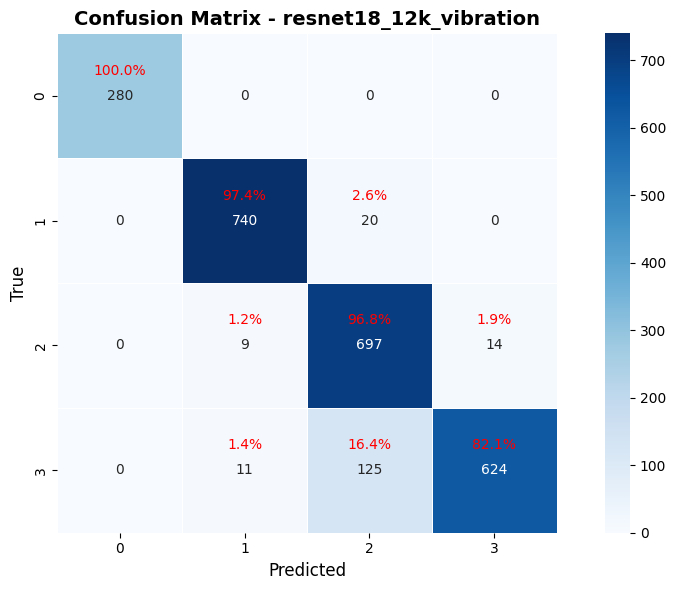


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.9290
Total de Amostras: 2520


In [29]:
results.show_results()

### 1D AlexNet

In [30]:
class AlexNet1D_12k(nn.Module):
    def __init__(self, input_length=12000, in_channel=1, num_classes=10):
        super(AlexNet1D_12k, self).__init__()
        
        self.features = nn.Sequential(
            # Conv1: Kernel 11 e Stride 4.
            # Reduz entrada 12000 -> ~3000
            nn.Conv1d(in_channel, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2), # 3000 -> 1500
            
            # Conv2
            nn.Conv1d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2), # 1500 -> 750
            
            # Conv3
            nn.Conv1d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv4
            nn.Conv1d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv5
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2), # 750 -> 375
        )
        
        self.avgpool = nn.AdaptiveAvgPool1d(6)
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            # 256 canais * 6 dimensão temporal = 1536 features
            nn.Linear(256 * 6, 1024), # Mantido 1024 conforme seu código (o paper original usa 4096)
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        # Tratamento de segurança para dimensão (Batch, 1, 12000)
        if x.ndim == 2:
            x = x.unsqueeze(1)
            
        x = self.features(x)
        x = self.avgpool(x)
        
        # Flatten robusto
        x = torch.flatten(x, 1)
        
        x = self.classifier(x)
        return x

In [31]:
# suppose dataset is already a DeepDataset like before
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")
model = AlexNet1D_12k(input_length=input_length, in_channel=1, num_classes=num_classes)

exp = DeepLearningExperiment(
    name="alexNet_12k_vibration",
    description="AlexNet for Raw Vibration (12k points)",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,  # numpy array of fold indexes
    model=model,
    batch_size=64,
    lr=3e-4,
    num_epochs=100
)

results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] Classifier training (100 epochs)...
  [Supervised] Epoch 1/100 Train Loss: 1.3280, Val Loss: 1.2923, Time: 2.28s
  [Supervised] Epoch 5/100 Train Loss: 0.9744, Val Loss: 0.9516, Time: 2.21s
  [Supervised] Epoch 10/100 Train Loss: 0.7092, Val Loss: 0.6997, Time: 2.21s
  [Supervised] Epoch 15/100 Train Loss: 0.5861, Val Loss: 0.5382, Time: 2.21s
  [Supervised] Epoch 20/100 Train Loss: 0.4398, Val Loss: 0.4576, Time: 2.20s
  [Supervised] Epoch 25/100 Train Loss: 0.4788, Val Loss: 0.4019, Time: 2.19s
  [Supervised] Epoch 30/100 Train Loss: 0.3291, Val Loss: 0.3629, Time: 2.20s
  [Supervised] Epoch 35/100 Train Loss: 0.2558, Val Loss: 0.2262, Time: 2.19s
  [Supervised] Epoch 40/100 Train Loss: 0.2248, Val Loss: 0.2314, Time: 2.19s
  [Supervised] Epoch 45/100 Train Loss: 0.2380, Val Loss: 0.3024, Time: 2.19s
  [Supervised] Epoch 50/100 Train Loss: 0.1636, Val Loss: 0.1520, Time: 2.19s
  [Supervised] Epoch 55/100 Train Loss:

EXPERIMENTO: alexNet_12k_vibration
DESCRIÇÃO: AlexNet for Raw Vibration (12k points)
MODELO: AlexNet1D_12k
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.8561
Desvio Padrão Acurácia ±0.0600
        F1-Score Médio  0.8545
Desvio Padrão F1-Score ±0.0620

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.7900   0.7839    0.8301 0.7900
    2   0.8625   0.8634    0.8715 0.8625
    3   0.9500   0.9503    0.9511 0.9500
    4   0.8219   0.8206    0.8281 0.8219


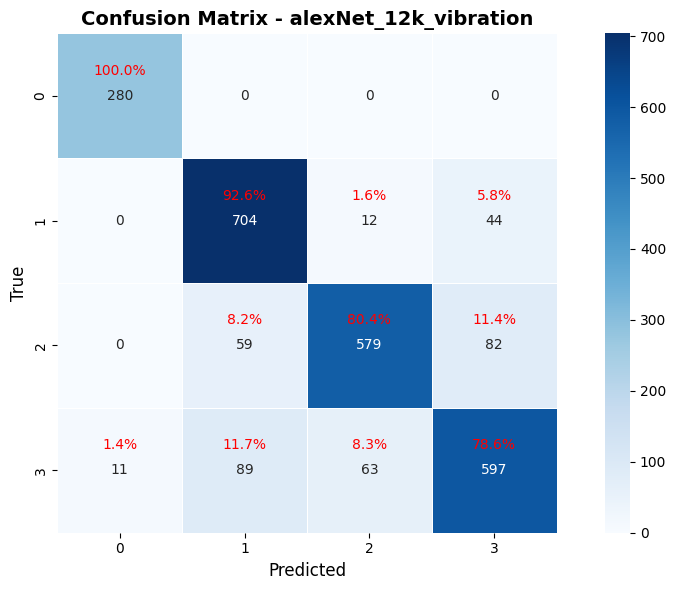


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.8571
Total de Amostras: 2520


In [32]:
results.show_results()

### 1D BiLSTM

In [33]:
class BiLSTM_12k(nn.Module):
    def __init__(self, in_channel=1, out_channel=10):
        super(BiLSTM_12k, self).__init__()
        
        # Hiperparâmetros Internos
        self.hidden_dim = 64
        self.kernel_num = 16
        self.num_layers = 2
        
        # self.V define o comprimento da sequência que entra na LSTM
        self.V = 100 

        # Camada de stem
        self.embed1 = nn.Sequential(
            # Kernel grande e Stride 4 para lidar com alta taxa de amostragem
            nn.Conv1d(in_channel, self.kernel_num, kernel_size=64, stride=4, padding=30),
            nn.BatchNorm1d(self.kernel_num),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        
        self.embed2 = nn.Sequential(
            nn.Conv1d(self.kernel_num, self.kernel_num*2, kernel_size=3, padding=1),
            nn.BatchNorm1d(self.kernel_num*2),
            nn.ReLU(inplace=True),
            # AdaptiveMaxPool força a saída a ter exatamente comprimento self.V (100) garantindo entrada constante para a LSTM
            nn.AdaptiveMaxPool1d(self.V)
        )
        
        # Camada Recorrente (BiLSTM)
        # Input Size: kernel_num*2 (32 features por passo de tempo)
        self.bilstm = nn.LSTM(
            input_size=self.kernel_num*2, 
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers, 
            bidirectional=True,
            batch_first=True, 
            bias=False
        )

        # Classificador
        # O input da linear é: Comprimento da Sequência (V) * (Hidden * 2 direções)
        self.hidden2label1 = nn.Sequential(
            nn.Linear(self.V * 2 * self.hidden_dim, 512),
            nn.ReLU(), 
            nn.Dropout(0.5)
        )
        
        self.hidden2label2 = nn.Linear(512, out_channel)

    def forward(self, x):
        # (Batch, 1, 12000)
        if x.ndim == 2:
            x = x.unsqueeze(1)
            
        # Extração de Features Convolucionais
        x = self.embed1(x)
        x = self.embed2(x) 
        # (Batch, 32, 100) -> (Batch, Channels, Time)
        
        # Preparação para LSTM
        # LSTM espera (Batch, Time, Features/Channels)
        x = x.permute(0, 2, 1) # (Batch, 100, 32)
        
        # Processamento Recorrente
        bilstm_out, _ = self.bilstm(x)
        bilstm_out = torch.tanh(bilstm_out)
        
        # Classificação
        bilstm_out = bilstm_out.reshape(bilstm_out.size(0), -1)
        
        logit = self.hidden2label1(bilstm_out)
        logit = self.hidden2label2(logit)

        return logit

In [34]:
# suppose dataset is already a DeepDataset like before
input_length = deep_dataset_time[0]['signal'][0].shape[-1]
num_classes = len(set([s['metainfo']['label'] for s in deep_dataset_time]))

print(f"Input length: {input_length}, Num classes: {num_classes}")
model = BiLSTM_12k(in_channel=1, out_channel=num_classes)

exp = DeepLearningExperiment(
    name="BiLSTM_12k_vibration",
    description="BiLSTM for Raw Vibration (12k points)",
    dataset=deep_dataset_time,
    data_fold_idxs=folds_singleround_deep,  # numpy array of fold indexes
    model=model,
    batch_size=64,
    lr=3e-4,
    num_epochs=100
)

results = exp.run()

Input length: 12000, Num classes: 4

=== Outer Fold 1/4 ===
[Fold 0] Classifier training (100 epochs)...
  [Supervised] Epoch 1/100 Train Loss: 1.1923, Val Loss: 1.3524, Time: 0.57s
  [Supervised] Epoch 5/100 Train Loss: 0.6086, Val Loss: 0.5807, Time: 0.28s
  [Supervised] Epoch 10/100 Train Loss: 0.3796, Val Loss: 0.3067, Time: 0.28s
  [Supervised] Epoch 15/100 Train Loss: 0.2096, Val Loss: 0.1797, Time: 0.34s
  [Supervised] Epoch 20/100 Train Loss: 0.1908, Val Loss: 0.1320, Time: 0.28s
  [Supervised] Epoch 25/100 Train Loss: 0.1203, Val Loss: 0.0944, Time: 0.29s
  [Supervised] Epoch 30/100 Train Loss: 0.1176, Val Loss: 0.1046, Time: 0.28s
  [Supervised] Epoch 35/100 Train Loss: 0.0930, Val Loss: 0.0710, Time: 0.29s
  [Supervised] Epoch 40/100 Train Loss: 0.1186, Val Loss: 0.0615, Time: 0.29s
  [Supervised] Epoch 45/100 Train Loss: 0.0618, Val Loss: 0.0475, Time: 0.28s
  [Supervised] Epoch 50/100 Train Loss: 0.0462, Val Loss: 0.0404, Time: 0.29s
  [Supervised] Epoch 55/100 Train Loss:

EXPERIMENTO: BiLSTM_12k_vibration
DESCRIÇÃO: BiLSTM for Raw Vibration (12k points)
MODELO: BiLSTM_12k
QUANTIDADE DE FOLDS: 4

MÉTRICAS GERAIS DO EXPERIMENTO:
--------------------------------------------------
               Métrica   Valor
        Acurácia Média  0.8889
Desvio Padrão Acurácia ±0.1021
        F1-Score Médio  0.8863
Desvio Padrão F1-Score ±0.1057

DETALHES POR FOLD:
------------------------------------------------------------
 Fold Acurácia F1-Score Precision Recall
    1   0.7150   0.7062    0.7866 0.7150
    2   0.9516   0.9514    0.9534 0.9516
    3   0.9703   0.9702    0.9706 0.9703
    4   0.9187   0.9176    0.9197 0.9187


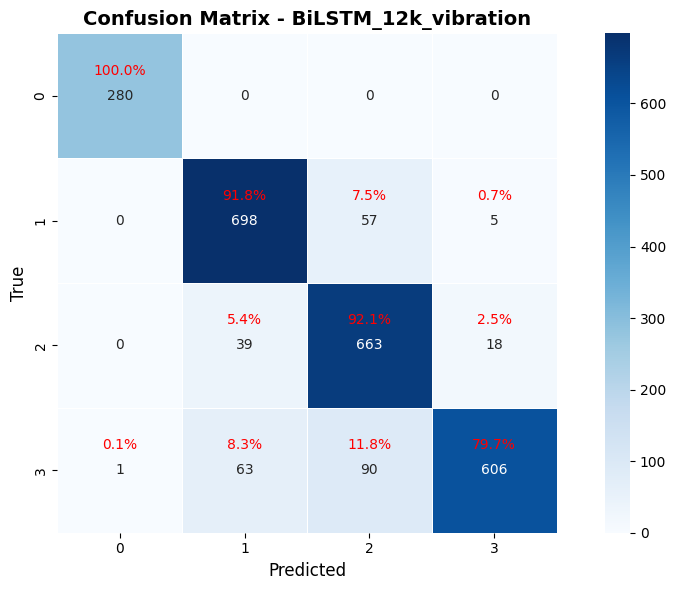


ESTATÍSTICAS DA MATRIZ DE CONFUSÃO:
Acurácia Geral: 0.8917
Total de Amostras: 2520


In [35]:
results.show_results()